In [1]:
import sys
sys.path.append("models/vector")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch_geometric.transforms as transforms

from auxiliary.visualization import visualize_losses, visualize_multiple_losses
from auxiliary.misc import send_notification, get_model_name

from initialize_vector import initialize_vector_model
from dataset_vector import BuildingVectorDataset, get_dummy_sample
from train_vector import train_vector_model
from features import important_features

from models.operators import elimination_operators, selection_operators

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [5]:
def load_training_validation_vector_dataset(operator_model, operators_to_predict, features, attach_roads, subset):
    '''Loads the training and validation dataset for the given model.'''
    # define path to training and validation data
    path_to_training_data = os.path.join(vector_path, "training_data", operator_model, "training")
    path_to_validation_data = os.path.join(vector_path, "training_data", operator_model, "validation")

    # construct training Dataset
    training_set = BuildingVectorDataset(path_to_training_data, 
                                         operators=operators_to_predict, 
                                         features=features,
                                         attach_roads=attach_roads, 
                                         transform=None,
                                         subset=subset)
    
    # construct validation Dataset (no transformations, no shuffling)
    validation_set = BuildingVectorDataset(path_to_validation_data, 
                                           operators=operators_to_predict, 
                                           features=features,
                                           attach_roads=attach_roads, 
                                           transform=None,
                                           subset=subset)

    return training_set, validation_set

def conduct_vector_model_training(architecture, operator_model, attach_roads, n_epochs, batch_size, device, subset=None):
    '''Given an architecture, model and further parameters, conducts a full training routine of the vector model.
    The loss history and the model are saved to disk.'''
    assert operator_model in ("elimination", "selection")
    assert architecture in ("hgnn", "hgt")

    if operator_model == "elimination":
        operators_to_predict = elimination_operators
    elif operator_model == "selection":
        operators_to_predict = selection_operators

    # define important features
    features = important_features[f"{architecture.upper()} {operator_model}"]

    # load dummy sample
    dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
    dummy_sample = get_dummy_sample(dummy_sample_path, 
                                    operators=operators_to_predict, 
                                    features=features, 
                                    attach_roads=attach_roads)

    # load training and validation data
    training_set, validation_set = load_training_validation_vector_dataset(operator_model=operator_model, 
                                                                           operators_to_predict=operators_to_predict, 
                                                                           features=features, 
                                                                           attach_roads=attach_roads, 
                                                                           subset=subset)    
    print(f"{len(training_set):,} samples in the training set.")
    print(f"{len(validation_set):,} samples in the validation set.")

    # initialize model
    model = initialize_vector_model(model=architecture, sample=dummy_sample, hidden_channels=128, num_heads=8, 
                                    num_layers=3, node_to_predict="focal_building")
    model.to(device)
    print(f"Using {model}")

    # get loss function and optimizer
    learning_rate = 0.0005
    criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # training the model
    model, training_losses, validation_losses, training_time = train_vector_model(model=model, 
                                                                                  device=device, 
                                                                                  optimizer=optimizer, 
                                                                                  criterion=criterion, 
                                                                                  n_epochs=n_epochs, 
                                                                                  batch_size=batch_size, 
                                                                                  validate=True, 
                                                                                  training_set=training_set, 
                                                                                  validation_set=validation_set, 
                                                                                  shuffle_training_set=True, 
                                                                                  shuffle_validation_set=False)
    
    # get a unique model name
    model_name = get_model_name(model, ops=operator_model[:3], attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, 
                                batch_size=batch_size, device=device)
    
    # saving the losses
    model_name_csv = model_name + ".csv"
    losses_path = os.path.join(vector_path, "model_outputs", operator_model, "losses", model_name_csv)
    
    # creating a DataFrame with loss values
    losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                              "training_loss": training_losses, 
                              "validation_loss": validation_losses})
    
    # save to CSV
    losses_df.to_csv(losses_path, index=False)
    
    # if working on ScienceCluster, send notification that training has finished
    if torch.cuda.is_available():
        send_notification(model=model, 
                          email_address="joris.senn@uzh.ch", 
                          n_samples=len(training_set), 
                          n_epochs=n_epochs, 
                          batch_size=batch_size, 
                          time=training_time)
    
    # save the trained model to disk
    path_to_models = os.path.join(vector_path, "models", operator_model)
    model_name_pth = model_name + ".pth"
    torch.save({"epoch": n_epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": criterion,
                }, os.path.join(path_to_models, model_name_pth))

    # visualize the loss curve of the trained model
    loss_path = os.path.join(vector_path, "model_outputs", operator_model, "losses")
    visualize_losses(model_name_csv, loss_path)

## Elimination model

In [6]:
# architecture: HGNN or HGT
architecture = "hgnn"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("hgnn", "hgt")

1,000 samples in the training set.
1,000 samples in the validation set.
Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Using HGNN with 481,665 parameters
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.685, validation loss: 0.672
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.647, validation loss: 0.632
Training time: 3.802 seconds


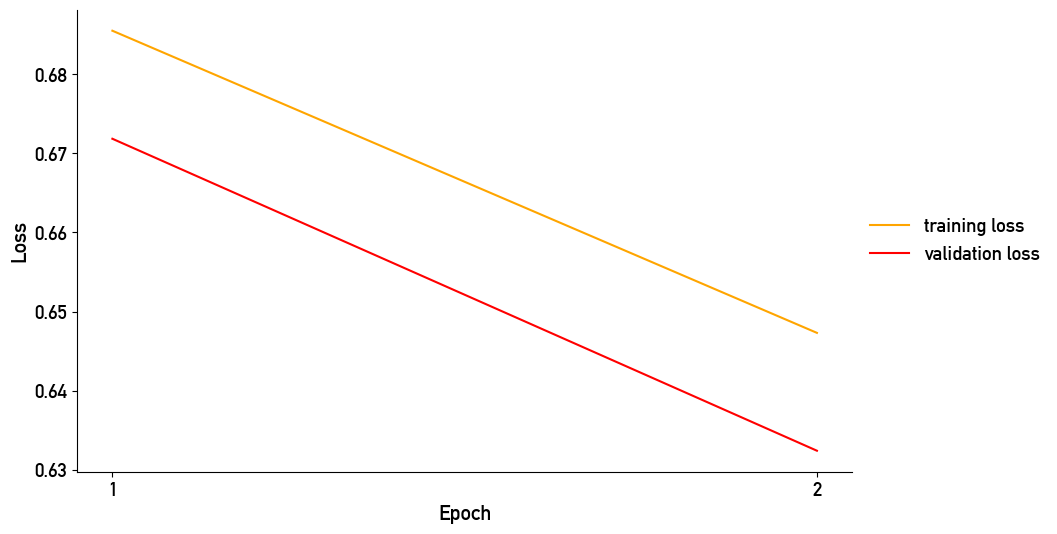

In [7]:
# conduct vector model training according to specifications
conduct_vector_model_training(architecture=architecture, 
                              operator_model="elimination", 
                              attach_roads=attach_roads, 
                              n_epochs=n_epochs, 
                              batch_size=batch_size, 
                              device=device, 
                              subset=1000)

## Selection model

In [8]:
# architecture: HGNN or HGT
architecture = "hgt"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("hgnn", "hgt")

1,000 samples in the training set.
1,000 samples in the validation set.
Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Using HGT with 750,389 parameters
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.688, validation loss: 0.687
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.684, validation loss: 0.688
Training time: 31.067 seconds


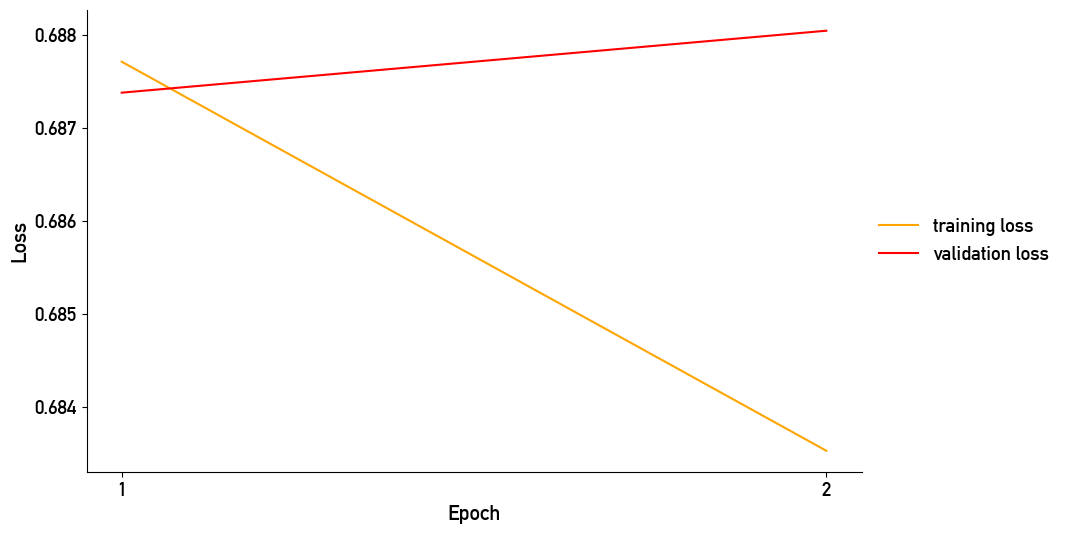

In [9]:
# conduct vector model training according to specifications
conduct_vector_model_training(architecture=architecture, 
                              operator_model="selection", 
                              attach_roads=attach_roads, 
                              n_epochs=n_epochs, 
                              batch_size=batch_size, 
                              device=device, 
                              subset=1000)

## Loss curves of vector models

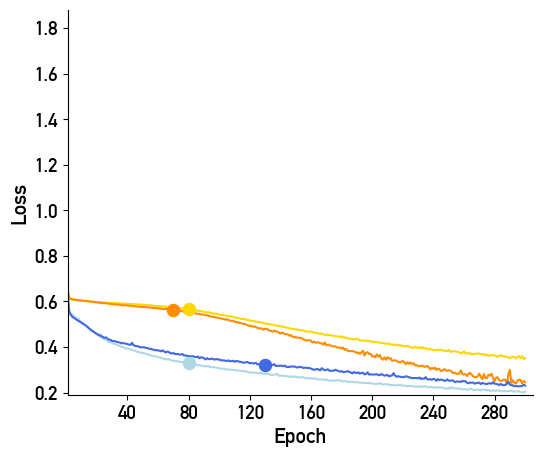

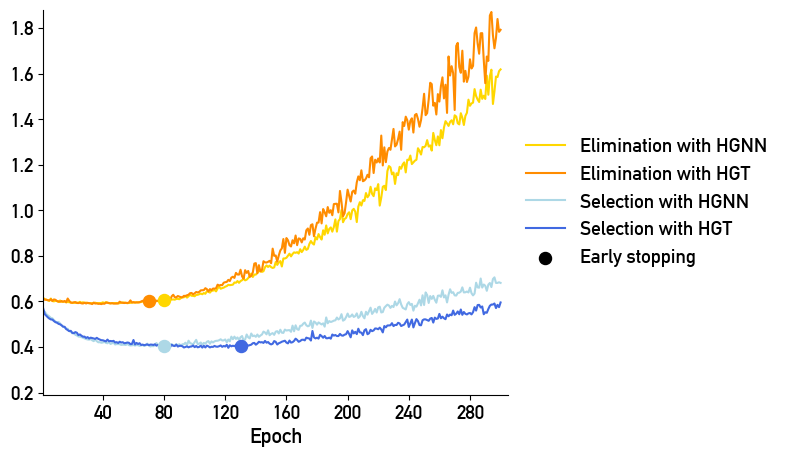

In [6]:
# loss path
model_losses = {"HGNN_eli_attachRoadsTrue_481665p_100000s_300ep_bs512_cuda.csv": 80, 
                "HGT_eli_attachRoadsTrue_700466p_100000s_300ep_bs512_cuda.csv": 70,
                "HGNN_sel_attachRoadsTrue_540548p_100000s_300ep_bs512_cuda.csv": 80,
                "HGT_sel_attachRoadsTrue_750389p_100000s_300ep_bs512_cuda.csv": 130}

visualize_multiple_losses(model_losses, 
                          path_to_data="../data.nosync", 
                          model="vector", 
                          epochs_every=40,
                          figsize=(6,5), 
                          save=True, 
                          output_path="../../Figures/Results/losses")